LangGraph 提供了内置的工具来可视化您的图

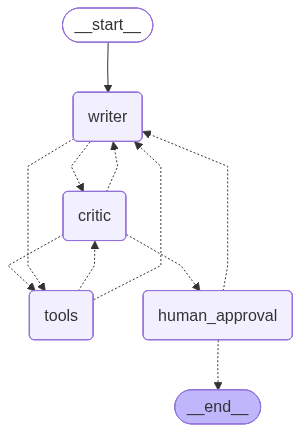

--- Starting Search Agent for: -f /Users/wuboxiong/Library/Jupyter/runtime/kernel-3520346f-0a28-4e5e-8399-c561f2896c2b.json ---
================================ Human Message =================================

-f /Users/wuboxiong/Library/Jupyter/runtime/kernel-3520346f-0a28-4e5e-8399-c561f2896c2b.json
================================== Ai Message ==================================
Name: writer

我主要专注于网络搜索和研究功能，无法直接访问您本地计算机上的文件路径。您提到的 `/Users/wuboxiong/Library/Jupyter/runtime/kernel-3520346f-0a28-4e5e-8399-c561f2896c2b.json` 文件看起来是Jupyter内核的运行时配置文件。

如果您需要帮助研究某个主题，我很乐意协助您进行网络搜索和信息整理。请告诉我您想了解什么内容，我会使用搜索工具为您查找相关信息并整理成报告。

例如，您可以告诉我：
- 您想了解的技术主题
- 需要研究的学术问题
- 需要查找的市场信息
- 或其他任何需要网络搜索的内容

请描述一下您希望我帮助您研究什么？
================================== Ai Message ==================================
Name: critic

我需要研究一个主题，请告诉我您想了解什么内容？我可以帮您搜索相关信息并整理成全面的报告。

例如：
- 技术发展（如AI、区块链、量子计算等）
- 科学发现
- 市场趋势
- 历史事件
- 文化现象
- 或其他任何您感兴趣的话题

请告诉我您希望我研究什么主题？
================================== Ai Message =================

KeyboardInterrupt: 

In [1]:
import sys
import re
import os
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from graph import app

def clean_filename(topic):
    """将 topic 转换为合法的文件名"""
    # 将非字母数字的字符替换为下划线，去掉多余下划线
    filename = re.sub(r'[^\w\s-]', '', topic).strip().lower()
    return re.sub(r'[-\s]+', '_', filename)


def main():
    if len(sys.argv) < 2:
        print("Usage: python main.py <topic>")
        sys.exit(1)
    
    topic = " ".join(sys.argv[1:])
    
    print(f"--- Starting Search Agent for: {topic} ---")
    
    system_prompt = (
        "You are a smart research assistant. "
        "Your goal is to research the user's topic using the web search and visit_page tools. "
        "1. Use `search_web` to find relevant pages. "
        "2. Use `visit_page` to read detailed content from promising URLs. "
        "3. Synthesize information into a comprehensive Markdown report. "
        "The document should have a clear title, headings, and bullet points. "
        "请用中文回答"
    )
    
    inputs = {"messages": [
        SystemMessage(content=system_prompt),
        HumanMessage(content=topic)
    ]}

    # 用于存储最后一条消息的内容,save as local markdown file
    final_content = ""
    
    for event in app.stream(inputs, stream_mode="values", config={"recursion_limit": 50}):
        message = event["messages"][-1]
        message.pretty_print()

        # 实时更新 final_content，如果是 Writer 的消息且有内容，就记录下来
        if isinstance(message, AIMessage) and message.content and getattr(message, 'name', None) == 'writer':
            final_content = message.content

    # --- 保存文件逻辑 ---
    if final_content:
        # 1. 创建 output 文件夹（如果不存在）
        output_dir = "output"
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        # 2. 生成文件名
        filename = f"{clean_filename(topic)}.md"
        filepath = os.path.join(output_dir, filename)
        
        # 3. 写入文件
        try:
            with open(filepath, "w", encoding="utf-8") as f:
                f.write(final_content)
            print(f"\n✅ Document saved successfully to: {filepath}")
        except Exception as e:
            print(f"\n❌ Failed to save document: {e}")
    else:
        print("\n⚠️ No content was generated to save.")


if __name__ == "__main__":
    from IPython.display import Image, display
    display(Image(app.get_graph().draw_mermaid_png()))

    main()


'''
Step 1: 启动与系统提示 (main.py)
程序开始，构建初始输入：
    SystemMessage: "你是研究助理...请搜索并总结..." (设定了 Agent 的人设和目标)。
    HumanMessage: "The future of quantum computing"。
调用 app.stream(inputs) 开始图的执行。
Step 2: 第一轮思考 (进入 graph.py 的 agent 节点)
    Input: System Prompt + User Query。
    LLM 处理: LLM 发现自己不知道量子计算的最新未来，且这需要外部知识。
    LLM Output: 返回一个 AIMessage，内容为空，但包含 tool_calls: name='search_web', args={'query': 'future of quantum computing'}。
    Edge 判断: tools_condition 检测到 tool_calls，将流向指引到 tools 节点。
Step 3: 执行工具 (进入 graph.py 的 tools 节点)
    Input: 上一步的 AIMessage (包含调用指令)。
    Action: ToolNode 解析指令，真正执行 search_web("future of quantum computing")。
    DDGS: 访问 DuckDuckGo，抓取 Top 5 结果。
    Output: 生成一个 ToolMessage，内容是搜索到的 JSON 字符串/文本。
    Edge: 强制流回 agent 节点。
Step 4: 第二轮思考 (回到 agent 节点)
Input (此时的状态):
    [0] SystemMessage
    [1] HumanMessage (User input)
    [2] AIMessage (I want to search...)
    [3] ToolMessage (Here are the search results...)
LLM 处理: LLM 阅读了 [3] 中的搜索结果。
    情况 A: 信息不够 -> LLM 再次生成 tool_calls (搜索另一个关键词)，循环回 Step 3。
    情况 B: 信息足够 -> LLM 开始根据 Prompt 的要求（撰写 Markdown 文档）进行综合。
LLM Output: 返回一个 AIMessage，内容是最终的 Markdown 总结文章。不包含 tool_calls。
Edge 判断: tools_condition 发现没有工具调用，路由到 END。
Step 5: 输出结果 (main.py)
    app.stream 也是一个生成器。在上述每一个 Step 完成时，main.py 中的循环都会收到更新的 event。
'''